In [3]:
import cv2
import numpy as np 
from glob import glob
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt

### FrameProcessing Class

This class is responsible for methods that will process each frame, such as the one that converts the image to its grayscale and the method that will extract the keypoints and process its descriptors

In [130]:
class FrameProcessing:
    def __init__(self):
        self.sift_object = cv2.xfeatures2d.SIFT_create()

    def gray(self, image):
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        return gray

    def features(self, image):
        keypoints, descriptors = self.sift_object.detectAndCompute(image, None)
        return [keypoints, descriptors]

### FileProcessing Class

This class is responsible for processing the files from dataset, getting the filenames based on the path to directory and also returninn a dictionary with all the frames per video file

In [131]:
class FileProcessing:
    def __init__(self):
        pass

    def getFiles(self, path):
        """
        - returns  a dictionary of all files 
        having key => value as  objectname => image path
        - returns total number of files.
        """
        imlist = {}
        count = 0
        for each in glob(path + "*"):
            word = each.split("/")[-1]
            imlist[word] = []
            for imagefile in glob(path+word+"/*/*.jpg"):
                im = cv2.imread(imagefile, 0)
                imlist[word].append(im)
                count += 1

        return [imlist, count]
    
    def getImagesPerVideo(self, path):
        """
        - returns  a dictionary of all files 
        having key => value as  objectname => image path
        - returns total number of files.
        """
        imlist = {}
        count = 0
        for each in glob(path + "*"):
            word = each.split("/")[-1]
            imlist[word] = []
            for videoFolder in glob(path+word+"/*"):
                video = videoFolder.split("/")[-1]
                frames = []
                for imagefile in glob(path + word + "/" + video + "/*.jpg"):
                    im = cv2.imread(imagefile, 0)
                    frames.append(im)
                    count += 1
                imlist[word].append(frames)
        return [imlist, count]

### Vocabulary Class

This class will generate a visual word vocabulary, based on training images that are provide to a K-Means algorithm, so it will cluster similar features into one

In [132]:
class VocabularyDeveloper:
    def __init__(self, path, n_clusters=20):
        # KMeans attributes
        self.n_clusters = n_clusters
        self.kmeans_obj = KMeans(n_clusters=n_clusters)
        self.kmeans_ret = None
        self.descriptor_vstack = None
        
        self.pathfile = path
        self.fileProcessing = FileProcessing()
        self.framesProcessing = FrameProcessing()
        self.descriptorsList = []
        self.images = None
        self.imagesCounter = 0
        self.classNames = {}
        
        self.vocabulary = None
        self.scale = None
        
    def generateDescriptorList(self):
        # read file. prepare file lists.
        self.images, self.imagesCounter = self.fileProcessing.getImagesPerVideo(
                                      self.pathfile)
        # extract SIFT Features from each image
        labelCounter = 0
        for word, videoList in self.images.items():
            self.classNames[str(labelCounter)] = word
            print("Computing Features for ", word)
            for video in videoList:
                for im in video:
                    kp, des = self.framesProcessing.features(im)
                    self.descriptorsList.append(des)
            labelCounter += 1
        print("Number of descriptors generated for " + str(self.imagesCounter) + " images: " + str(len(self.descriptorsList)))
    
    def performCluster(self):
        print("Performing clustering")
        self.descriptor_vstack = self.formatND(self.descriptorsList)
        self.kmeans_ret = self.kmeans_obj.fit_predict(self.descriptor_vstack)
        self.plotClusterResult()
        
    def formatND(self, l):
        """
        restructures list into vstack array of shape
        M samples x N features for sklearn
        """
        vStack = np.array(l[0])
        for remaining in l[1:]:
            vStack = np.vstack((vStack, remaining))
        self.descriptor_vstack = vStack.copy()
        
        print(self.descriptor_vstack.shape)
        return vStack
    
    def developVocabulary(self, kmeans_ret=None):
        """
        Each cluster denotes a particular visual word
        Every image can be represeted as a combination of multiple
        visual words. The best method is to generate a sparse histogram
        that contains the frequency of occurence of each visual word

        Thus the vocabulary comprises of a set of histograms of encompassing
        all descriptions for all images
        """

        #Generating list of descriptors
        self.generateDescriptorList()
        
        #Clustering the list
        self.performCluster()
        
        #Generating vocabulary itself
        self.vocabulary = np.array(
            [np.zeros(self.n_clusters) for i in range(self.imagesCounter)])
        old_count = 0
        for i in range(self.imagesCounter):
            l = len(self.descriptorsList[i])
            for j in range(l):
                if kmeans_ret is None:
                    idx = self.kmeans_ret[old_count+j]
                else:
                    idx = self.kmeans_ret[old_count+j]
                self.vocabulary[i][idx] += 1
            old_count += l
        print("Vocabulary Histogram Generated")
        
        #Standardizing the histogram
        self.standardize()
        
    def standardize(self, std=None):
        """
        standardize is required to normalize the distribution
        wrt sample size and features. If not normalized, the classifier may become
        biased due to steep variances.
        """
        if std is None:
            self.scale = StandardScaler().fit(self.vocabulary)
            self.vocabulary = self.scale.transform(self.vocabulary)
        else:
            print("STD not none. External STD supplied")
            self.vocabulary = std.transform(self.vocabulary)
            
    def plotHist(self, vocabulary=None):
        print("Plotting histogram")
        if vocabulary is None:
            vocabulary = self.vocabulary
            
        x_scalar = np.arange(self.n_clusters)
        y_scalar = np.array([abs(np.sum(vocabulary[:, h], dtype=np.int32))
                             for h in range(self.n_clusters)])

        plt.bar(x_scalar, y_scalar)
        plt.xlabel("Visual Word Index")
        plt.ylabel("Frequency")
        plt.title("Complete Vocabulary Generated")
        plt.xticks(x_scalar + 0.4, x_scalar)
        plt.show()
        
    def plotClusterResult(self):
        print("Number of clusters:" + str(self.n_clusters))
        print("Plotting cluster result")
        
        centers = self.kmeans_obj.cluster_centers_
        print(centers.shape)
        plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
        
    def getKMeansObject(self):
        return self.kmeans_obj
    
    def getImages(self):
        return self.images
    
    def getNumberOfClusters(self):
        return self.n_clusters
    

### Visual Word Representation Class

Given a vocabulary, it will be responsible for generating visual word histograms for each video that contains a specific quantity of frames

In [173]:
class VisualWordRepresentation:
    def __init__(self, vocabulary):
        self.vocabulary = vocabulary
        self.fp = FrameProcessing()
        self.nClusters = self.vocabulary.getNumberOfClusters()
    
    def buildFrameHistogram(self, image):
        print("Generating histogram for image")
        histogram = np.zeros(len(self.vocabulary.getKMeansObject().cluster_centers_))
        [kp, des] = self.fp.features(image)
        cluster_result = self.vocabulary.getKMeansObject().predict(des)
        for i in cluster_result:
            histogram[i] += 1.0
        x_scalar = np.arange(self.nClusters)
        y_scalar = np.array([abs(np.sum(histogram[h], dtype=np.int32))
                             for h in range(self.nClusters)])
        plt.bar(x_scalar, y_scalar)
        plt.xlabel("Visual Word Index")
        plt.ylabel("Frequency")
        plt.title("Histogram for frame ")
        plt.xticks(x_scalar + 0.4, x_scalar)
        plt.show()    
    
    def buildVideoHistogram(self, label):
        videosFromLabel = self.vocabulary.getImages()[label]
        for number, video in enumerate(videosFromLabel):
            histogram = np.zeros(len(self.vocabulary.getKMeansObject().cluster_centers_))
            for im in video:
                [kp, des] = self.fp.features(im)
                cluster_result = self.vocabulary.getKMeansObject().predict(des)
                for i in cluster_result:
                    histogram[i] += 1.0
            x_scalar = np.arange(self.nClusters)
            y_scalar = np.array([abs(np.sum(histogram[h], dtype=np.int32))
                                 for h in range(self.nClusters)])
            plt.bar(x_scalar, y_scalar)
            plt.xlabel("Visual Word Index")
            plt.ylabel("Frequency")
            plt.title("Histogram for video " + str(number) + " , label " + label)
            plt.xticks(x_scalar + 0.4, x_scalar)
            plt.show()    

Computing Features for  3
Computing Features for  0
Number of descriptors generated for 40 images: 40
Performing clustering
(44042, 128)
Number of clusters:20
Plotting cluster result
(20, 128)
Vocabulary Histogram Generated


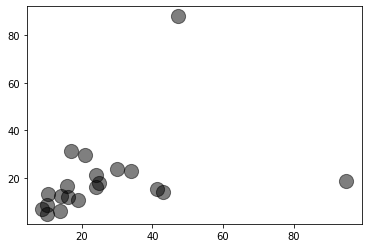

In [144]:
pathTest = "/home/fabiana/Desktop/projeto-final-src/datasets/SmallTest/"
#Codebook with size 110
v = VocabularyDeveloper(pathTest, n_clusters=20)
v.developVocabulary()

In [177]:
train_path = "/home/fabiana/Desktop/projeto-final-src/datasets/MediumTest/"

Computing Features for  OK
Computing Features for  3
Computing Features for  5
Computing Features for  0
Number of descriptors generated for 440 images: 440
Performing clustering
(422318, 128)
Number of clusters:110
Plotting cluster result
(110, 128)
Vocabulary Histogram Generated


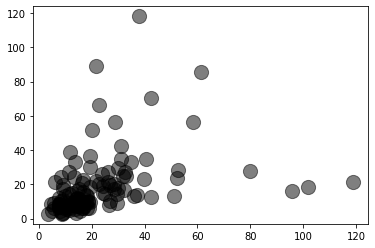

In [98]:
#Codebook with size 110
vd1 = VocabularyDeveloper(train_path, n_clusters=110)
vd1.developVocabulary()

Computing Features for  OK
Computing Features for  3
Computing Features for  5
Computing Features for  0
Number of descriptors generated for 440 images: 440
Performing clustering
(422318, 128)
Number of clusters:220
Plotting cluster result
(220, 128)
Vocabulary Histogram Generated


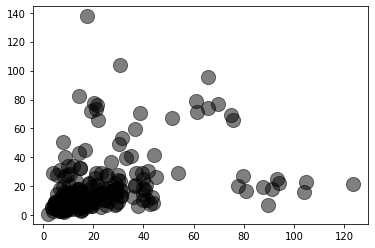

In [99]:
#Codebook with size 220
vd2 = VocabularyDeveloper(train_path, n_clusters=220)
vd2.developVocabulary()